<a href="https://colab.research.google.com/github/robertchoi/BatteryDatasetImplementation/blob/master/LSTM%EB%82%B4%EB%B6%80%EC%A0%80%ED%95%AD_model7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from keras.layers import RNN
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import layers, models
from sklearn import preprocessing
from keras import datasets
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn import model_selection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
forecasting = 20

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0222_20110307012737_cell_7.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,7,0.296,2.25,-20
1,2011.3.7 18:29,7,0.297,2.25,-20
2,2011.3.8 6:29,7,0.298,2.25,-20
3,2011.3.8 18:29,7,0.298,2.25,-20
4,2011.3.9 6:29,7,0.296,2.25,-20
...,...,...,...,...,...
250,2011.8.30 5:28,7,0.619,2.29,-20
251,2011.8.30 17:28,7,0.620,2.30,-20
252,2011.8.31 5:28,7,0.623,2.30,-20
253,2011.8.31 16:09,7,0.639,2.30,-20


In [ ]:
df = df.drop(['CellNo', 'MeasuredDate'], axis=1)
df

,Resistance,Volt,Temp
0,0.296,2.25,-20
1,0.297,2.25,-20
2,0.298,2.25,-20
3,0.298,2.25,-20
4,0.296,2.25,-20
...,...,...,...
250,0.619,2.29,-20
251,0.620,2.30,-20
252,0.623,2.30,-20
253,0.639,2.30,-20


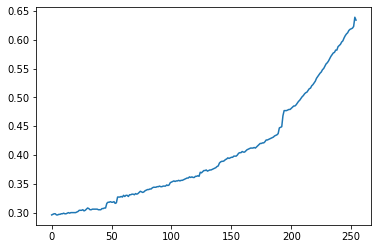

In [ ]:
df['Resistance'].plot()
train = df

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

     Volt  Temp  Resistance
0     0.0   0.0    0.000000
1     0.0   0.0    0.002915
2     0.0   0.0    0.005831
3     0.0   0.0    0.005831
4     0.0   0.0    0.000000
..    ...   ...         ...
250   0.8   0.0    0.941691
251   1.0   0.0    0.944606
252   1.0   0.0    0.953353
253   1.0   0.0    1.000000
254   1.0   0.0    0.985423

[255 rows x 3 columns]


In [ ]:
train = df_scaled

In [ ]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [ ]:
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)


In [ ]:
model = Sequential()
model.add(LSTM(30, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=True)
          )
model.add(LSTM(30,
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(3))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('C:/Users/wlsrm/data', 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_train, y_train, 
                    epochs=1000, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid))

Epoch 1/1000
12/12 [==============================] - 3s 84ms/step - loss: 0.1360 - mse: 0.1360 - val_loss: 0.0490 - val_mse: 0.0490
Epoch 2/1000
12/12 [==============================] - 1s 60ms/step - loss: 0.0654 - mse: 0.0654 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 3/1000
12/12 [==============================] - 1s 59ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 4/1000
12/12 [==============================] - 1s 54ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 5/1000
12/12 [==============================] - 1s 61ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 6/1000
12/12 [==============================] - 1s 57ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 7/1000
12/12 [==============================] - 1s 59ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 8/1000
12/12 [==============================] - 1s 58ms/step - 

Test Score:  [0.004534883890300989, 0.004534883890300989]


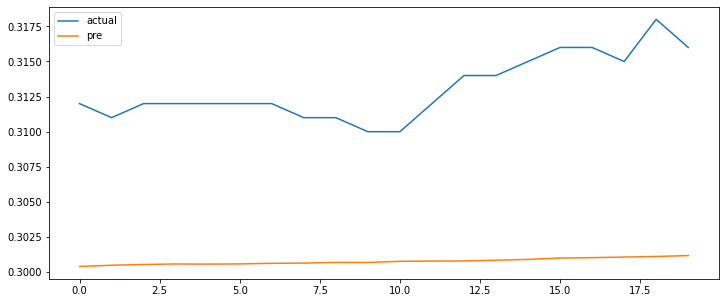

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = seq*0.7


test = test.iloc[0:round(seq),:]
test, seq
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, forecasting)
look_ahead=forecasting
xhat = test_feature[0]
predictions = np.zeros((look_ahead, 3))
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(test_feature, test_label, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

plt.figure(figsize=(12,5))
plt.plot(label[-forecasting:],label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

Test Score:  [0.0030701837968081236, 0.0030701837968081236]


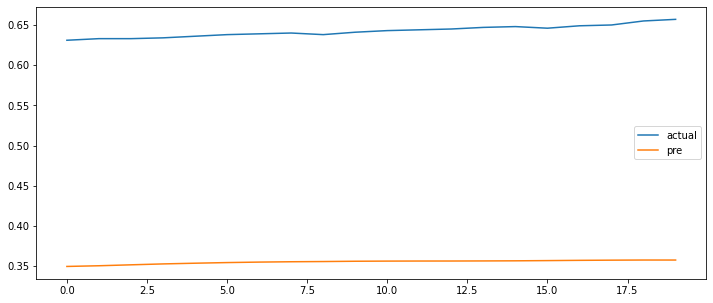

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = seq*0.7


test = test.iloc[0:round(seq),:]
test, seq
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, forecasting)
look_ahead=forecasting
xhat = test_feature[0]
predictions = np.zeros((look_ahead, 3))
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(test_feature, test_label, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

plt.figure(figsize=(12,5))
plt.plot(label[-forecasting:],label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

Test Score:  [0.0031035610008984804, 0.0031035610008984804]


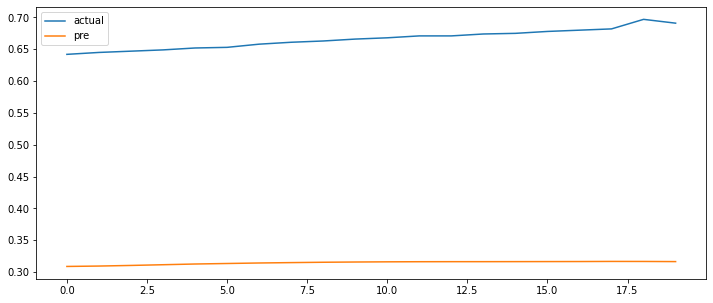

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = seq*0.7


test = test.iloc[0:round(seq),:]
test, seq
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, forecasting)
look_ahead=forecasting
xhat = test_feature[0]
predictions = np.zeros((look_ahead, 3))
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(test_feature, test_label, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

plt.figure(figsize=(12,5))
plt.plot(label[-forecasting:],label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

Test Score:  [0.003912505693733692, 0.003912505693733692]


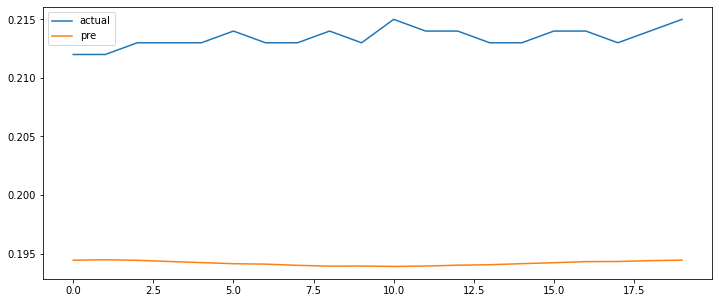

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = seq*0.7


test = test.iloc[0:round(seq),:]
test, seq
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, forecasting)
look_ahead=forecasting
xhat = test_feature[0]
predictions = np.zeros((look_ahead, 3))
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(test_feature, test_label, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

plt.figure(figsize=(12,5))
plt.plot(label[-forecasting:],label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

Test Score:  [0.0049745794385671616, 0.0049745794385671616]


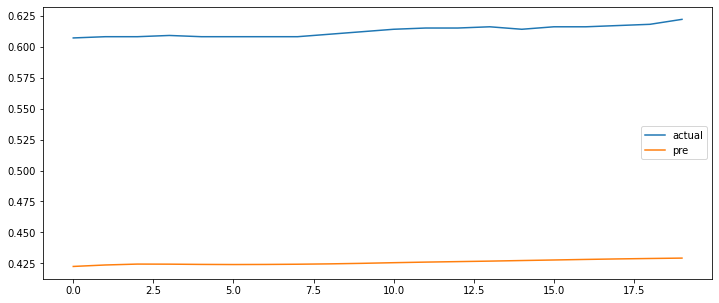

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = seq*0.7


test = test.iloc[0:round(seq),:]
test, seq
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, forecasting)
look_ahead=forecasting
xhat = test_feature[0]
predictions = np.zeros((look_ahead, 3))
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(test_feature, test_label, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

plt.figure(figsize=(12,5))
plt.plot(label[-forecasting:],label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

Test Score:  [0.004558037966489792, 0.004558037966489792]


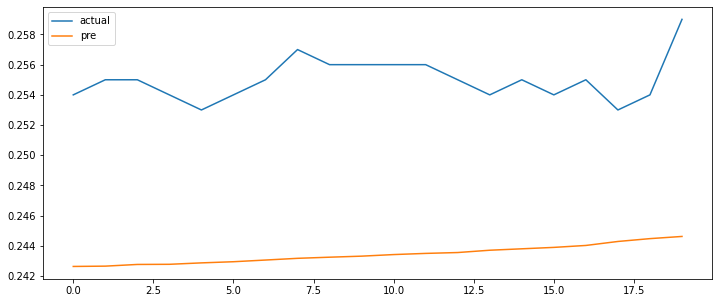

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = seq*0.7


test = test.iloc[0:round(seq),:]
test, seq
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, forecasting)

look_ahead=forecasting
xhat = test_feature[0]
predictions = np.zeros((look_ahead, 3))
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(test_feature, test_label, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

plt.figure(figsize=(12,5))
plt.plot(label[-forecasting:],label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

Test Score:  [0.003196482080966234, 0.003196482080966234]


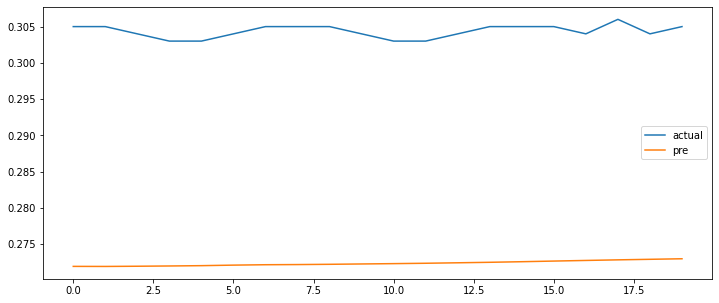

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = seq*0.7


test = test.iloc[0:round(seq),:]
test, seq
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, forecasting)
look_ahead=forecasting
xhat = test_feature[0]
predictions = np.zeros((look_ahead, 3))
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(test_feature, test_label, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

plt.figure(figsize=(12,5))
plt.plot(label[-forecasting:],label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

Test Score:  [0.00917102862149477, 0.00917102862149477]


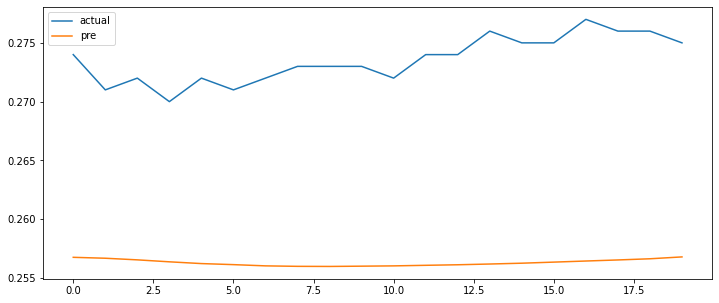

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')
# print(test_df)
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = seq*0.7


test = test.iloc[0:round(seq),:]
test, seq
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, forecasting)
look_ahead=forecasting
xhat = test_feature[0]
predictions = np.zeros((look_ahead, 3))
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])
# print(test_label[-6:])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(test_feature, test_label, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

plt.figure(figsize=(12,5))
plt.plot(label[-forecasting:],label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

        MeasuredDate  CellNo  Resistance  Volt  Temp
0      2011.3.7 6:27      23       0.333  2.24   -20
1     2011.3.7 18:29      23       0.333  2.24   -20
2      2011.3.8 6:29      23       0.332  2.24   -20
3     2011.3.8 18:29      23       0.333  2.24   -20
4      2011.3.9 6:29      23       0.333  2.24   -20
..               ...     ...         ...   ...   ...
246  2011.8.29 17:28      23       0.524  2.27   -20
247   2011.8.30 5:28      23       0.524  2.27   -20
248  2011.8.30 17:28      23       0.528  2.27   -20
249   2011.8.31 5:28      23       0.528  2.27   -20
250  2011.8.31 16:12      23       0.535  2.27   -20

[251 rows x 5 columns]
Test Score:  [0.0008227769867517054, 0.0008227769867517054]


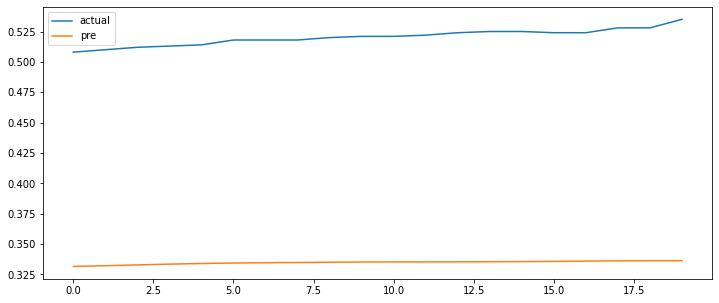

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')
print(test_df)
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = seq*0.7


test = test.iloc[0:round(seq),:]
test, seq
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, forecasting)
look_ahead=forecasting
xhat = test_feature[0]
predictions = np.zeros((look_ahead, 3))
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(test_feature, test_label, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

plt.figure(figsize=(12,5))
plt.plot(label[-forecasting:],label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()